# Assignment 1
## [Section 1]
This section will make you familier with 
1. some pytorch basics
2. how to train a simple model with linear layers and non-linearity activation layer
3. the effect of number of layers

In [1]:
# Import dependencies
import random
import numpy as np
import torch
import torch.nn as nn

from matplotlib import pyplot as plt
from matplotlib.pyplot import plot, title, axis

In [3]:
# Set up your device 
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
print(device)
# o=torch.full((5,5),1)
# row2=torch.full((1,5),2)
# col2=torch.full((5,1),2)
# o[1]=row2
# print(o)
# print((o[:,2]))

cuda:0


In [4]:
# Set up random seed to 1008. Do not change the random seed.
# Yes, these are all necessary when you run experiments!
seed = 1008
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [5]:
# These helper functions are for visualization later
def set_default(figsize=(10, 10), dpi=100):
    plot.style.use(['dark_background', 'bmh'])
    plot.rc('axes', facecolor='k')
    plot.rc('figure', facecolor='k')
    plot.rc('figure', figsize=figsize, dpi=dpi)

def show_scatterplot(X, colors, title=''):
    colors = colors.cpu().numpy()
    X = X.cpu().numpy()
    plt.figure()
    plt.axis('equal')
    plt.scatter(X[:, 0], X[:, 1], c=colors, s=30)
    # plt.grid(True)
    plt.title(title)
    plt.axis('off')

def plot_bases(bases, width=0.04):
    bases = bases.cpu()
    bases[2:] -= bases[:2]
    plt.arrow(*bases[0], *bases[2], width=width, color=(1,0,0), zorder=10, alpha=1., length_includes_head=True)
    plt.arrow(*bases[1], *bases[3], width=width, color=(0,1,0), zorder=10, alpha=1., length_includes_head=True)

# 1. Tensor [1 pt]
Write a function `build_tensor()` that returns the 2D tensor with integers below. **Do not use any loops**.

```
1 2 1 1 1 1 2 1 1 1 1 2 1
2 2 2 2 2 2 2 2 2 2 2 2 2
1 2 1 1 1 1 2 1 1 1 1 2 1
1 2 1 3 3 1 2 1 3 3 1 2 1
1 2 1 3 3 1 2 1 3 3 1 2 1
1 2 1 1 1 1 2 1 1 1 1 2 1
2 2 2 2 2 2 2 2 2 2 2 2 2
1 2 1 1 1 1 2 1 1 1 1 2 1
1 2 1 3 3 1 2 1 3 3 1 2 1
1 2 1 3 3 1 2 1 3 3 1 2 1
1 2 1 1 1 1 2 1 1 1 1 2 1
2 2 2 2 2 2 2 2 2 2 2 2 2
1 2 1 1 1 1 2 1 1 1 1 2 1
```


Hint: Use `torch.full`, `torch.fill_`, and the slicing operator.

In [6]:
def build_tensor():
    outt = torch.full((13, 13), 1)
    row2 = torch.full((1, 13), 2)
    col2 = torch.full((13, 1), 2)
    outt[[1, 6, 11]] = row2
    outt[:, [1, 6, 11]] = col2
    outt[[3, 3, 4, 4], [3, 4, 3, 4]] = 3
    outt[[8, 8, 9, 9], [8, 9, 8, 9]] = 3
    outt[[3, 3, 4, 4], [8, 9, 8, 9]] = 3
    outt[[8, 8, 9, 9], [3, 4, 3, 4]] = 3
    return outt

In [7]:
# You can use this assertion to make sure the answer is right.
# Before diving into the next question, you should pass the test.
assert (build_tensor() == 
        torch.tensor([[1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [1, 2, 1, 3, 3, 1, 2, 1, 3, 3, 1, 2, 1],
        [1, 2, 1, 3, 3, 1, 2, 1, 3, 3, 1, 2, 1],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [1, 2, 1, 3, 3, 1, 2, 1, 3, 3, 1, 2, 1],
        [1, 2, 1, 3, 3, 1, 2, 1, 3, 3, 1, 2, 1],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1]])).all()

# 2. To Loop or not to loop [3 pts]

The following questions are intended to give you a flavor of looping.

## 2.1. `mul_row_loop` [1 pt]
Write a function `mul_row_loop`, using python loops (O(mn)) with simple indexing but no advanced indexing/slicing, that receives a 2D tensor as input and returns a tensor of same size that is 
- equal to the input on the first row
- 2 times the input's second row on the second row
- 3 times the input's third row on the third row
- etc..

For instance:
```
>>> t = torch.full((4, 8), 2.0)
>>> t
tensor([[2., 2., 2., 2., 2., 2., 2., 2.],
[2., 2., 2., 2., 2., 2., 2., 2.],
[2., 2., 2., 2., 2., 2., 2., 2.],
[2., 2., 2., 2., 2., 2., 2., 2.]])
>>> mul_row(t)
tensor([[2., 2., 2., 2., 2., 2., 2., 2.],
[4., 4., 4., 4., 4., 4., 4., 4.],
[6., 6., 6., 6., 6., 6., 6., 6.],
[8., 8., 8., 8., 8., 8., 8., 8.]])
```

In [8]:
def mul_row_loop(input_tensor):
    for i in range(len(input_tensor)):
        for j in range(len(input_tensor[0])):
            input_tensor[i][j]*=(i+1)
    return input_tensor

In [9]:
# You can use this assertion to make sure the answer is right.
# Before step into the next question, you should pass the test.
assert (mul_row_loop(build_tensor()) == torch.tensor([[ 1,  2,  1,  1,  1,  1,  2,  1,  1,  1,  1,  2,  1],
        [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
        [ 3,  6,  3,  3,  3,  3,  6,  3,  3,  3,  3,  6,  3],
        [ 4,  8,  4, 12, 12,  4,  8,  4, 12, 12,  4,  8,  4],
        [ 5, 10,  5, 15, 15,  5, 10,  5, 15, 15,  5, 10,  5],
        [ 6, 12,  6,  6,  6,  6, 12,  6,  6,  6,  6, 12,  6],
        [14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14],
        [ 8, 16,  8,  8,  8,  8, 16,  8,  8,  8,  8, 16,  8],
        [ 9, 18,  9, 27, 27,  9, 18,  9, 27, 27,  9, 18,  9],
        [10, 20, 10, 30, 30, 10, 20, 10, 30, 30, 10, 20, 10],
        [11, 22, 11, 11, 11, 11, 22, 11, 11, 11, 11, 22, 11],
        [24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24],
        [13, 26, 13, 13, 13, 13, 26, 13, 13, 13, 13, 26, 13]])).all()

# 2.2. `mul_row_fast` [1 pt]
Write a second version of the same function named `mul_row_fast` which uses tensor operations and no looping.

**Hint**: Use broadcasting and `torch.arange`, `torch.view`, and `torch.mul`.

In [10]:
def mul_row_fast(input_tensor):
    num=torch.arange(1,1+len(input_tensor)).view(len(input_tensor),1)
    input_tensor=torch.mul(input_tensor,num)
    return input_tensor

In [11]:
# You can use this assertion to make sure the answer is right.
assert (mul_row_fast(build_tensor()) == mul_row_loop(build_tensor())).all()

# 2.3. `times` [1 pt]
Write a function `times` which takes a 2D tensor as input and returns the run times of `mul_row_loop` and `mul_row_fast` on this tensor, respectively. Use `time.perf_counter`.

Use `torch.ones` to create a 2D tensor of size (1000, 400) full of ones and run `times` on it (there should be more than three orders of magnitude difference).

In [13]:
from time import perf_counter
def times(input_tensor):
    start1=perf_counter()
    mul_row_loop(input_tensor)
    end1=perf_counter()
    start2=perf_counter()
    mul_row_fast(input_tensor)
    end2=perf_counter()
    return end1-start1,end2-start2
    
input_tensor = torch.ones(1000,400)
time_1, time_2 = times(input_tensor)
print('{}, {}'.format(time_1, time_2))

4.99824000000001, 0.00035060000004705216


# 3. Non-linearities [2 pts]
 
In this section, we will explore and get comfortable initializing modules like nn.Linear and using non-linearities in PyTorch.

## 3.1. ReLU [1 pt]
ReLU (Rectified Linear Unit) is a non-linear activation fuction defined as:

$$y = \mathrm{max}(0,x)$$

Define a fully connected neural network `linear_fc_relu` which:
- takes 2 dimensional data as input and passes it through linear modules (`torch.nn.Linear`)
- has one hidden layer of dimension 5 
- has output dimension of 2
- has ReLU as an activation function

Create a tensor with input data $X$ of size (100, 2) using `torch.randn` and send it to device.

Hint: there are two torch.nn.Linear layers, and a non-linearity activation is after one linear layer

In [14]:
# Input data
X = torch.randn(100,2)

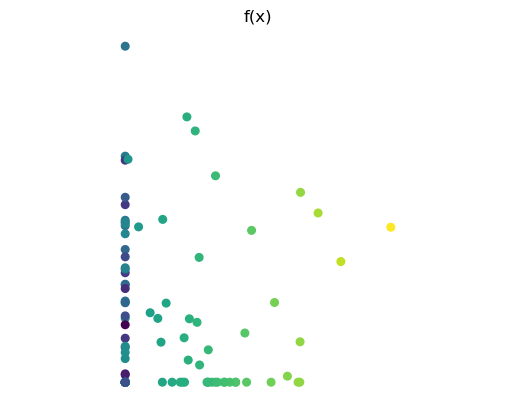

In [15]:
# create 1-layer(hidden) neural networks with ReLU activation
linear_fc_relu =nn.ReLU()

# Visualize the output of linear_fc_relu model with random initialization
linear_fc_relu.to(device)
with torch.no_grad():
    Y = linear_fc_relu(X)
colors = X[:, 0]
show_scatterplot(Y, colors, title='f(x)')

## 3.2. Sigmoid [1 pt]
The sigmoid function is another popular choice for a non-linear activation function which maps its input to values in the interval $(0,1)$. It is formally defined as:

$$\sigma(x) = \frac{1}{1+ exp[-x]}$$

Define a new neural network `linear_fc_sigmoid` which is the same architecture as in part `3.1.` but with a sigmoid unit instead of ReLU. 

Using the same $X$ as in part `3.1`, visualize the output of passing `X` through the neural network `linear_fc_sigmoid`.

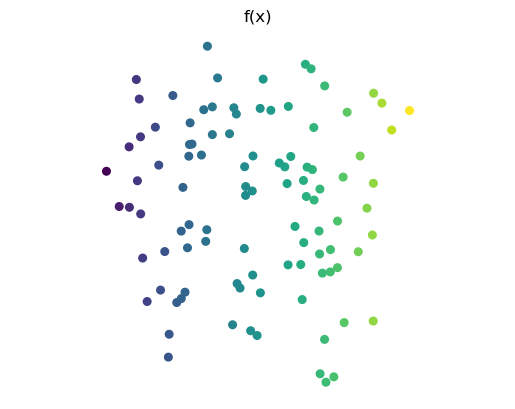

In [16]:
# create 1-layer neural networks with Sigmoid activation
linear_fc_sigmoid =nn.Sigmoid()

# Visualize the output of linear_fc_sigmoid model with random initialization
linear_fc_sigmoid.to(device)
with torch.no_grad():
    Y = linear_fc_sigmoid(X)
colors = X[:, 0]
show_scatterplot(Y, colors, title='f(x)')

# 4. Pipeline [4 pts]

In this section, we will explore some linear classifiers with different layer numbers and learn how to build a pipeline of training. 

In [21]:
# Define data generating functions
def quadratic_data_generator(data_size):
    # generate an input tensor of size data_size with torch.randn
    x = torch.randn(data_size, 1) - 2   
    x = x.to(device)
    # calculate y = x^2 + 4x - 3
    y = pow(x,2)+4*4-3
    return x, y

def cubic_data_generator(data_size=100):
    # f(x) = y = x^3 + 4x^2 - 3
    # generate an input tensor of size data_size with torch.randn
    x = torch.randn(data_size, 1) - 2   
    x = x.to(device)
    
    # calculate y = x^3 + 4x^2 - 3
    y =pow(x,3)+4*pow(x,2)-3

    return x, y

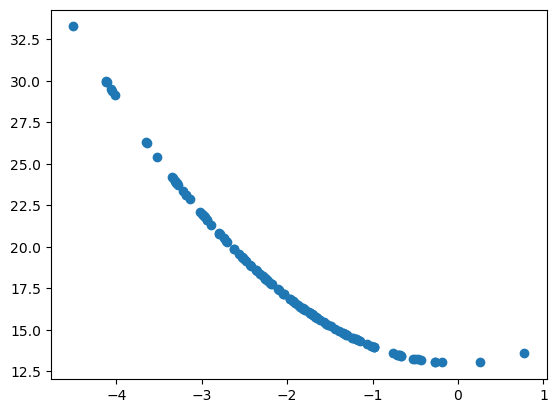

In [24]:
# Generate the data with 128 datapoints
# print(device)
x, y = quadratic_data_generator(128)
xx=x.cpu()
yy=y.cpu()
plt.scatter(xx,yy)
plt.show()

In [25]:
# Define a Linear Classifier with a single linear layer and no non-linearity
# (no hidden layer)
class Linear_0H(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = nn.Linear(1,1)

    def forward(self, x):
        return self.classifier(x)

In [26]:
# Define a Linear Classifier with a single hidden layer of size 5 and ReLU non-linearity
class Linear_1H(nn.Module):
    def __init__(self):
        super().__init__()

        self.classifier = nn.Sequential(
            nn.Linear(1,1),
            nn.ReLU()
            )

    def forward(self, x):
        return self.classifier(x)

In [27]:
# Define a Linear Classifier with a two hidden layers of size 5 and ReLU non-linearity
class Linear_2H(nn.Module):
    def __init__(self):
        super().__init__()

        self.classifier = nn.Sequential(
            nn.Linear(1,1),
            nn.ReLU(),
            nn.ReLU()
                        )

    def forward(self, x):
        return self.classifier(x)

In [28]:
'''
TODO: Training function

Hint: look at some example pytorch tutorials to learn how to
    - initialize optimizers
    - zero gradient
    - backprop the loss
    - step the gradient


Note: This is full batch. We compute forward on whole x, y.
No need for dataloaders nor loop over batches. 
Just pass all of x to model's forward pass.
'''
def train(model, epochs, x, y):

    # Send model to device
    # TODO
    model.to(device)
    # Set model to training mode
    model.train()
    
    # Define MSE loss function
    criterion = nn.MSELoss()
    
    # TODO: Define the SGD optimizer with learning rate 0.01
    import torch.optim as optim
    # optimizer = # TODO
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        
        # TODO: Forward data through model to predict y
        y_pred = model.forward(x)
        
        # TODO: Compute loss in terms of predicted and true y
        loss = criterion(y,y_pred)

        # TODO: Zero gradient
        optimizer.zero_grad()
        # TODO: call backward on loss
        loss.backward()
        # TODO: step the optimizer
        optimizer.step()
        # every 500 epochs, print
        if (epoch+1) % 500 == 0:
            print('Epoch {} loss: {}'.format(epoch+1, loss.item()))
            
    # return y_pred without gradient information, for plotting
    return y_pred.detach()

The code below is to visualize the prediction. You may get different curves by running multiple times because of random initialization.

Epoch 500 loss: 2.1191537380218506
Epoch 1000 loss: 1.884539246559143
Epoch 1500 loss: 1.8762943744659424
Epoch 2000 loss: 1.876004695892334
Epoch 2500 loss: 1.8759944438934326
Epoch 3000 loss: 1.8759942054748535
Epoch 3500 loss: 1.8759942054748535
Epoch 4000 loss: 1.8759942054748535
Epoch 4500 loss: 1.8759942054748535
Epoch 5000 loss: 1.8759942054748535


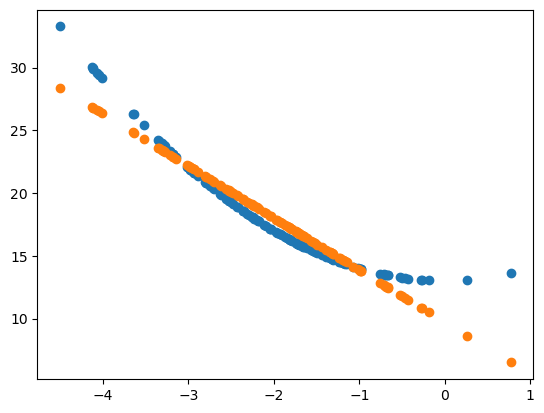

In [29]:
# 0H model on quadratic data
model = Linear_0H()
y_pred = train(model, epochs=5000, x=x, y=y)

# Plot predictions vs actual data
plt.scatter(x.cpu(), y.cpu())
plt.scatter(x.cpu(), y_pred.cpu())
plt.show()

Epoch 500 loss: 2.2463438510894775
Epoch 1000 loss: 1.889008641242981
Epoch 1500 loss: 1.8764513731002808
Epoch 2000 loss: 1.8760101795196533
Epoch 2500 loss: 1.8759945631027222
Epoch 3000 loss: 1.8759942054748535
Epoch 3500 loss: 1.8759942054748535
Epoch 4000 loss: 1.8759942054748535
Epoch 4500 loss: 1.8759942054748535
Epoch 5000 loss: 1.8759942054748535


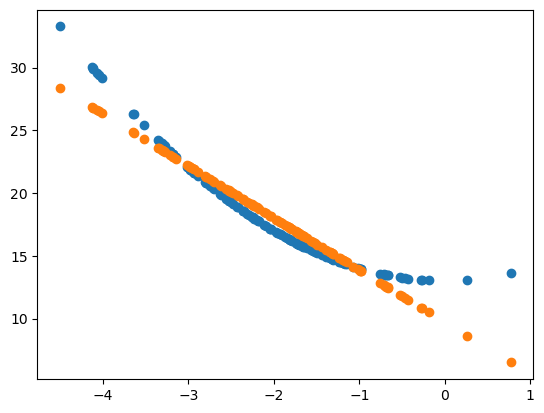

In [30]:
# 1H model on quadratic data
model = Linear_1H()
y_pred = train(model, epochs=5000, x=x, y=y)
plt.scatter(x.cpu(), y.cpu())
plt.scatter(x.cpu(), y_pred.cpu())
plt.show()

Epoch 500 loss: 2.187131404876709
Epoch 1000 loss: 1.8869279623031616
Epoch 1500 loss: 1.8763785362243652
Epoch 2000 loss: 1.8760075569152832
Epoch 2500 loss: 1.8759948015213013
Epoch 3000 loss: 1.875994324684143
Epoch 3500 loss: 1.8759942054748535
Epoch 4000 loss: 1.8759942054748535
Epoch 4500 loss: 1.8759942054748535
Epoch 5000 loss: 1.8759942054748535


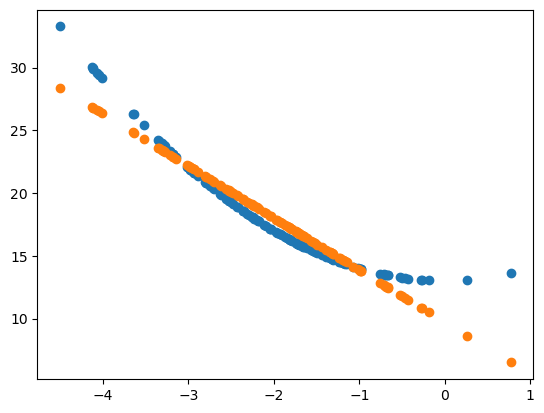

In [31]:
# 2H model on quadratic data
model = Linear_2H()
y_pred = train(model, epochs=5000, x=x, y=y)
plt.scatter(x.cpu(), y.cpu())
plt.scatter(x.cpu(), y_pred.cpu())
plt.show()

In [32]:
# Generate cubic data with 128 data points
x, y = cubic_data_generator(128)

Epoch 500 loss: 26.84208106994629
Epoch 1000 loss: 26.81565284729004
Epoch 1500 loss: 26.814838409423828
Epoch 2000 loss: 26.81481170654297
Epoch 2500 loss: 26.814809799194336
Epoch 3000 loss: 26.814809799194336
Epoch 3500 loss: 26.81481170654297
Epoch 4000 loss: 26.81481170654297
Epoch 4500 loss: 26.81481170654297
Epoch 5000 loss: 26.81481170654297


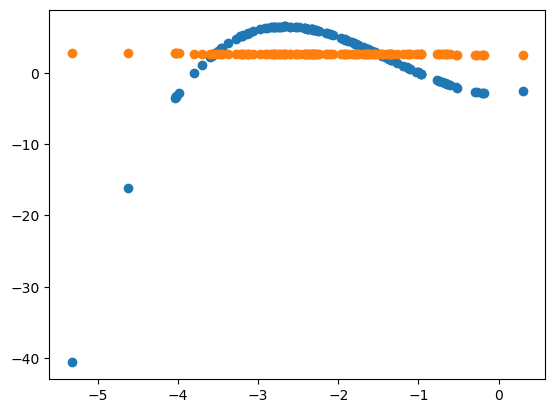

In [33]:
# 0H model on cubic data
model = Linear_0H()
y_pred = train(model, epochs=5000, x=x, y=y)
plt.scatter(x.cpu(), y.cpu())
plt.scatter(x.cpu(), y_pred.cpu())
plt.show()

Epoch 500 loss: 26.831518173217773
Epoch 1000 loss: 26.81532859802246
Epoch 1500 loss: 26.814823150634766
Epoch 2000 loss: 26.81481170654297
Epoch 2500 loss: 26.814809799194336
Epoch 3000 loss: 26.8148136138916
Epoch 3500 loss: 26.81481170654297
Epoch 4000 loss: 26.81481170654297
Epoch 4500 loss: 26.81481170654297
Epoch 5000 loss: 26.81481170654297


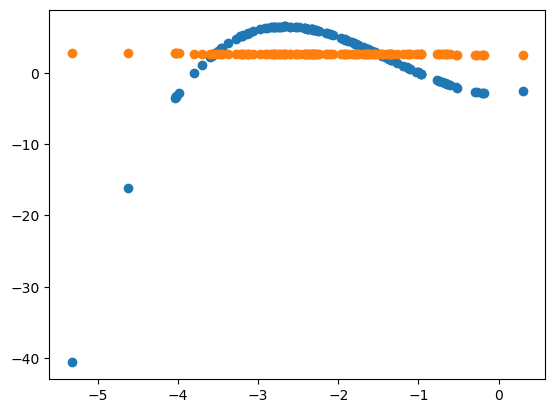

In [34]:
# 1H model on cubic data
model = Linear_1H()
y_pred = train(model, epochs=5000, x=x, y=y)
plt.scatter(x.cpu(), y.cpu())
plt.scatter(x.cpu(), y_pred.cpu())
plt.show()

Epoch 500 loss: 26.83553695678711
Epoch 1000 loss: 26.815448760986328
Epoch 1500 loss: 26.814828872680664
Epoch 2000 loss: 26.8148136138916
Epoch 2500 loss: 26.814809799194336
Epoch 3000 loss: 26.81481170654297
Epoch 3500 loss: 26.81481170654297
Epoch 4000 loss: 26.81481170654297
Epoch 4500 loss: 26.81481170654297
Epoch 5000 loss: 26.81481170654297


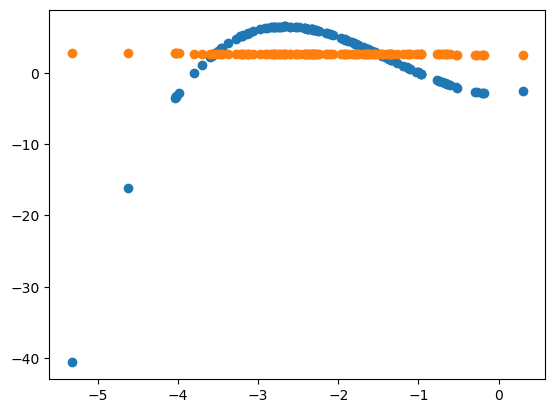

In [35]:
# 2H model on cubic data
model = Linear_2H()
y_pred = train(model, epochs=5000, x=x, y=y)
plt.scatter(x.cpu(), y.cpu())
plt.scatter(x.cpu(), y_pred.cpu())
plt.show()